# Airline Reviews with NLP

In this notebook, we'll explore methods for analyzing text using Airline Reviews data.

# Import packages

In [102]:
# data processing
import numpy as np
import pandas as pd

# text processing and NLP
import nltk
from textblob import TextBlob

# gensim for topic modeling
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# viz
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

# misc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import re
import warnings
warnings.filterwarnings("ignore")

print('Packages successfully imported.')

Packages successfully imported.


# Load data

In [103]:
df = pd.read_csv('Multiple Airline Reviews.csv')

print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

df.head()

Shape of the dataset: (23171, 20)
Columns in the dataset: Index(['Unnamed: 0', 'Airline Name', 'Overall_Rating', 'Review_Title',
       'Review Date', 'Verified', 'Review', 'Aircraft', 'Type Of Traveller',
       'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Food & Beverages', 'Ground Service',
       'Inflight Entertainment', 'Wifi & Connectivity', 'Value For Money',
       'Recommended'],
      dtype='object')


,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,Nov-19,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,Jun-19,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,Jun-19,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,Sep-19,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,Sep-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


## Classification

In [104]:
df1=df.copy()

In [105]:
# Define the Ratingclass column
def categorize_rating(overall_rating):
    if overall_rating <= 5:
        return 'LowRating'
    elif 6 <= overall_rating <= 7:
        return 'MediumRating'
    else:
        return 'HighRating'

# Convert Overall_Rating to numeric and create Ratingclass
df1['Overall_Rating'] = pd.to_numeric(df1['Overall_Rating'], errors='coerce')
df1['Ratingclass'] = df1['Overall_Rating'].apply(categorize_rating)

# Drop rows with missing Ratingclass
df1 = df1.dropna(subset=['Ratingclass'])

# Display the distribution of the Ratingclass
rating_class_distribution = df1['Ratingclass'].value_counts()
rating_class_distribution


Ratingclass
LowRating       16936
HighRating       4367
MediumRating     1868
Name: count, dtype: int64

In [106]:
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill missing reviews with an empty string
df1['Review'] = df1['Review'].fillna('')

# Prepare independent variables (IVs) and dependent variable (DV)
X = df1[['Review', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
          'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
          'Value For Money']]
y = df1['Ratingclass']

# Handle missing numeric values in independent variables
numeric_features = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
                    'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
                    'Value For Money']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Text vectorization for the 'Review' column
text_transformer = TfidfVectorizer(max_features=1000, stop_words='english')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, 'Review')
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create a pipeline for classification
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model to the training data
model_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

accuracy


              precision    recall  f1-score   support

  HighRating       0.58      0.63      0.61      1310
   LowRating       0.86      0.94      0.90      5081
MediumRating       0.95      0.04      0.07       561

    accuracy                           0.81      6952
   macro avg       0.80      0.53      0.52      6952
weighted avg       0.82      0.81      0.78      6952



0.8050920598388953

# Pre-processing

In [107]:
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove leading/trailing whitespace
    return text

In [108]:
df['content_c'] = df['Review'].apply(preprocess_text)

df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,content_c
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,...,Nov-19,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes,moroni to moheli turned out to be a pretty dec...
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,...,Jun-19,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no,moroni to anjouan it is a very small airline m...
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,...,Jun-19,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no,anjouan to dzaoudzi a very small airline and t...
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,...,Sep-19,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no,please do a favor yourself and do not fly with...
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,...,Sep-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,do not book a flight with this airline my frie...


In [109]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame:", total_null_values)

Total null values in the DataFrame: 80996


In [110]:
df.fillna('', inplace=True)

In [111]:
def fix_ordinal_date(date_string):
    if isinstance(date_string, float):
        return ""
    date_string = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_string)
    return date_string

df['Review Date'] = df['Review Date'].apply(fix_ordinal_date)
df['Review Date'] = pd.to_datetime(df['Review Date'])

In [112]:
df = df[['content_c', 'Overall_Rating', 'Review Date']]
df.head()

,content_c,Overall_Rating,Review Date
0,moroni to moheli turned out to be a pretty dec...,9,2019-11-11
1,moroni to anjouan it is a very small airline m...,1,2019-06-25
2,anjouan to dzaoudzi a very small airline and t...,1,2019-06-25
3,please do a favor yourself and do not fly with...,1,2019-09-28
4,do not book a flight with this airline my frie...,1,2019-09-24


In [113]:
print("Earliest review date:", df['Review Date'].min())
print("Latest review date:", df['Review Date'].max())

Earliest review date: 2002-01-06 00:00:00
Latest review date: 2023-07-27 00:00:00


# EDA

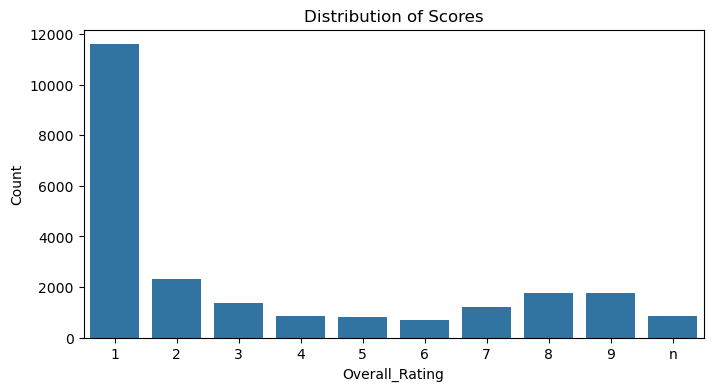

In [114]:
# analyzing score distribution
score_counts = df['Overall_Rating'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.xlabel('Overall_Rating')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()


NLP

In [115]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [116]:
df['sentiment'] = df['content_c'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))

In [117]:
df[['content_c', 'Overall_Rating', 'sentiment_label']]

,content_c,Overall_Rating,sentiment_label
0,moroni to moheli turned out to be a pretty dec...,9,positive
1,moroni to anjouan it is a very small airline m...,1,neutral
2,anjouan to dzaoudzi a very small airline and t...,1,neutral
3,please do a favor yourself and do not fly with...,1,negative
4,do not book a flight with this airline my frie...,1,positive
...,...,...,...
23166,bangkok to tokyo ive flown many low cost airli...,1,neutral
23167,avoid at all costs i booked flights to go from...,1,positive
23168,flight was leaving at and after an hour and a...,3,neutral
23169,zipair is jals budget airline they dont have c...,6,positive


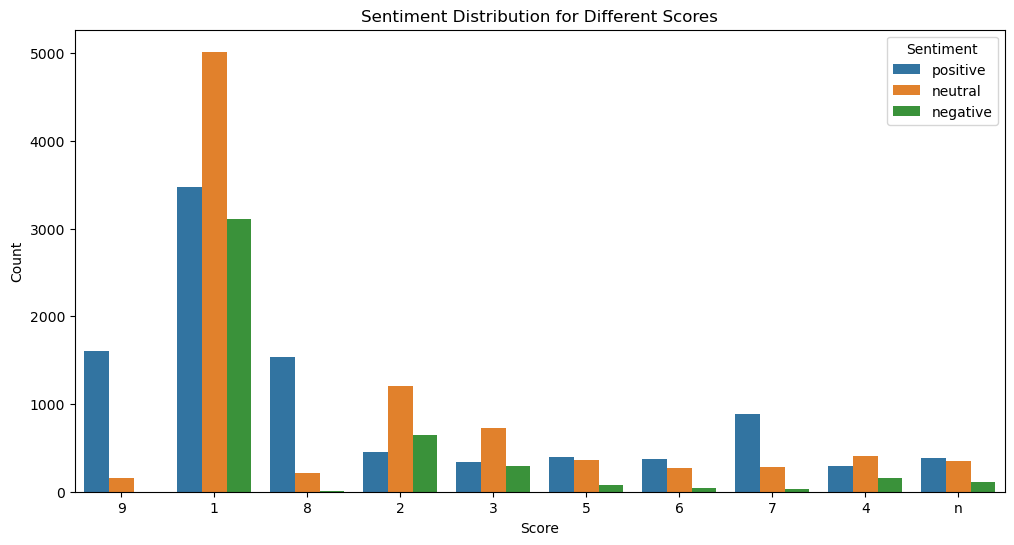

In [118]:
# sentiment distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Overall_Rating', hue='sentiment_label')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Sentiment Distribution for Different Scores')
plt.legend(title='Sentiment')
plt.show()

Sentiment analysis accurately identify positives and negatives.

# Word cloud

Analyzing negative reviews

In [119]:
# add our list of stopwords
stopwords = set(STOPWORDS)
stopwords.update(['flight', 'gate', 'cancelled', 'delayed', 'airways', 'route', 'crew']) # creating a custom list based on domain knowledge

In [120]:
negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['content_c'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)

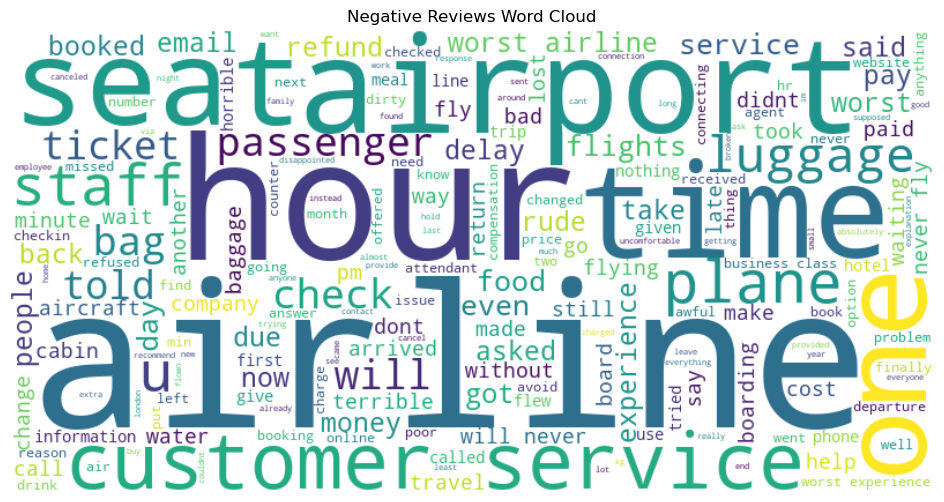

In [121]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

Word cloud reveals common issues like seat , hour time , luggage, customer service ,airline etc

# Topic modeling

Scope: negative reviews

In [122]:
# preprocess text data in content_c

def preprocess_text_data(text):
    tokens = [token for token in text.lower().split() if token.isalnum()] # tokenize text and remove stopwords
    return tokens

texts = [preprocess_text(text) for text in df[df['sentiment_label']=='negative']['content_c']]

In [123]:
texts[:5]

['please do a favor yourself and do not fly with adria on the route from munich to pristina in july  they lost my luggage and for  days in a row despite numerous phone calls they were not able to locate it  days later the luggage arrived at the destination completely ruined applying for compensation they ignored my request foolishly again i booked another flight with them  euros frankfurt  pristina in september  they cancelled the flight with no reason  hours before the departure desperate phone calls to customer service to get anything rerouting compensation etc were not responded i will never fly again with adria what a disgrace shame on you adria for constantly deceiving your customers',
 'ljubljana to zürich firstly ljubljana airport is terrible badly trained staff unfriendly toilets are very dirty flight  hours delayed without any information there is no information desk so questions arent possible never again will use this airline its even worse than the budget airlines and thats

In [124]:
tokenized_texts = [simple_preprocess(text) for text in texts]
tokenized_texts = [[word for word in doc if word not in stopwords] for doc in tokenized_texts] # remove stopwords

# create dict and corpus
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_texts]

In [125]:
tokenized_texts[0][:5]

['please', 'favor', 'fly', 'adria', 'munich']

# LDA model

Extract topics that cause dissastisfaction among users

In [126]:
# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, workers=2)

In [127]:
# print topics
topics = lda_model.print_topics(-1)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.012*"service" + 0.009*"customer" + 0.008*"airline" + 0.008*"airport" + 0.008*"refund" + 0.007*"us" + 0.007*"will" + 0.006*"worst" + 0.006*"never" + 0.006*"de"
Topic 1: 0.017*"airline" + 0.013*"service" + 0.010*"staff" + 0.009*"worst" + 0.009*"customer" + 0.008*"hours" + 0.007*"one" + 0.007*"experience" + 0.007*"seats" + 0.007*"ticket"
Topic 2: 0.018*"us" + 0.010*"airline" + 0.009*"service" + 0.009*"one" + 0.008*"luggage" + 0.007*"will" + 0.007*"hours" + 0.007*"time" + 0.007*"hour" + 0.007*"worst"
Topic 3: 0.016*"airline" + 0.014*"never" + 0.010*"luggage" + 0.010*"will" + 0.009*"airport" + 0.009*"time" + 0.007*"experience" + 0.007*"hours" + 0.007*"check" + 0.006*"flights"
Topic 4: 0.019*"airline" + 0.013*"worst" + 0.012*"service" + 0.009*"airport" + 0.008*"us" + 0.007*"one" + 0.007*"customer" + 0.006*"time" + 0.006*"hours" + 0.006*"bad"


Visualize extract topics from LDA model

In [128]:
# visualize topics
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)